# Import data

In [1]:
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

test_ratio = 0.25
calibration_ratio = 0.5
alpha = 0.1

sklearn_data = fetch_california_housing()
X, y = sklearn_data.data, sklearn_data.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=2023)
x_train, x_cal, y_train, y_cal = train_test_split(x_train, y_train, test_size=calibration_ratio, random_state=2023)

# 1. Mean regression

In [2]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

## Trained ACPI 

In [3]:
from sklearn.metrics import mean_absolute_error
from acpi import ACPI

# It has the same params as a Random Forest, and it should be tuned to predict the score of calibration set.  
acpi = ACPI(model_cali=model, n_estimators=100, max_depth=20, min_node_size=10)

acpi.fit(x_cal, y_cal, nonconformity_func=None)
# You can use custom nonconformity score by using the argument 'nonconformity_func'. 
# It takes a callable[[ndarray, ndarray], ndarray] that return the nonconformity 
# score given (predictions, y_true). By the default, it uses absolute residual if the model 
# is mean estimates and max(pred_lower - y, y - pred_upper) if the model is quantile estimates.

v_cal = acpi.nonconformity_score(model.predict(x_cal), y_cal) 

# Optimize the RF to predict the nonconformity score

## Fit ACPI calibration

In [4]:
acpi.fit_calibration(x_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)

100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


## Compute Prediction Intervals

In [5]:
y_lower, y_upper = acpi.predict_pi(x_test, method='qrf')

# Or the prediction sets if the model is a classifier (NOT TESTED YET)
# y_pred_set = acpi.predict_pi(x_test, method='qrf')

## Results

In [6]:
from acpi.utils import compute_coverage
import matplotlib.pyplot as plt
import numpy as np

In [7]:
coverage_qrf = compute_coverage(
    y_test,
    y_lower,
    y_upper)

print('Coverage QRF = ', coverage_qrf)

Coverage QRF =  0.9007751937984496


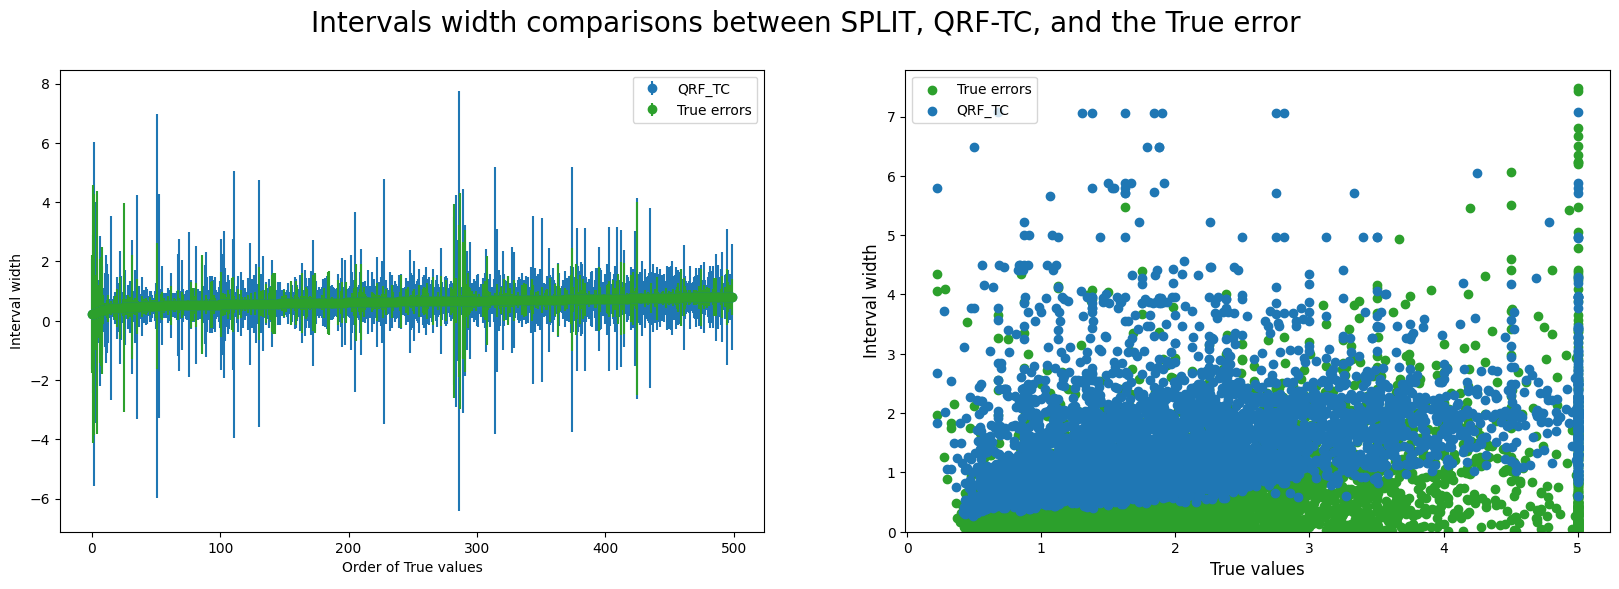

In [8]:
idx = list(range(len(y_test)))
sort_id = np.argsort(y_test)
max_size = 500

y_lower_true = model.predict(x_test) - np.abs(model.predict(x_test) - y_test)
y_upper_true = model.predict(x_test) + np.abs(model.predict(x_test) - y_test)
r = {'QRF_TC': y_upper - y_lower, 'True': y_upper_true - y_lower_true}

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].errorbar(idx[:max_size], y_test[sort_id][:max_size], yerr=r['QRF_TC'][sort_id][:max_size], fmt='o', label='QRF_TC', color='tab:blue')
ax[0].errorbar(idx[:max_size], y_test[sort_id][:max_size], yerr=r['True'][sort_id][:max_size], fmt='o', label='True errors', color='tab:green')
ax[0].set_ylabel('Interval width')
ax[0].set_xlabel('Order of True values')
ax[0].legend()

ax[1].scatter(y_test, r['True'], label='True errors', color='tab:green')
ax[1].scatter(y_test, r['QRF_TC'], label='QRF_TC', color='tab:blue')
ax[1].set_xlabel("True values", fontsize=12)
ax[1].set_ylabel("Interval width", fontsize=12)
ax[1].set_xscale("linear")
ax[1].set_ylim([0, np.max(r['QRF_TC'])*1.1])
ax[1].legend()

plt.suptitle('Intervals width comparisons between SPLIT, QRF-TC, and the True error ', size=20)
plt.show()

# 2. Quantile Regression 

In [9]:
from lightgbm import LGBMRegressor

quantile_lower = LGBMRegressor(objective='quantile', alpha=alpha/2, random_state=2023)
quantile_upper = LGBMRegressor(objective='quantile', alpha=1-alpha/2, random_state=2023)

quantile_lower.fit(x_train, y_train)
quantile_upper.fit(x_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 7740, number of used features: 8
[LightGBM] [Info] Start training from score 0.665950
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 7740, number of used features: 8
[LightGBM] [Info] Start training from score 4.857649


LGBMRegressor(alpha=0.95, objective='quantile', random_state=2023)

In [10]:
class QuantileModelPI:
    def __init__(self, model_lower, model_upper):
        self.model_lower = model_lower
        self.model_upper = model_upper
    
    def predict(self, x_test):
        pi = np.zeros(shape=(x_test.shape[0], 2))
        pi[:, 0] = self.model_lower.predict(x_test)
        pi[:, 1] = self.model_upper.predict(x_test)
        return pi
        
quantile_estimator = QuantileModelPI(quantile_lower, quantile_upper)

## Trained and predict PI of Quantile Regression model using ACPI

In [11]:
from sklearn.metrics import mean_absolute_error
from acpi import ACPI

# It has the same params as a Random Forest, and it should be tuned to predict the score of calibration set.  
acpi = ACPI(model_cali=quantile_estimator, n_estimators=100, max_depth=20, min_node_size=10)

acpi.fit(x_cal, y_cal, nonconformity_func=None)
# You can use custom nonconformity score by using the argument 'nonconformity_func'. 
# It takes a callable[[ndarray, ndarray], ndarray] that return the nonconformity 
# score given (predictions, y_true). By the default, it uses absolute residual if the model 
# is mean estimates and max(pred_lower - y, y - pred_upper) if the model is quantile estimates.

v_cal = acpi.nonconformity_score(quantile_estimator.predict(x_cal), y_cal) 

# Optimize the RF to predict the nonconformity score

In [ ]:
acpi.fit_calibration(x_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)

 24%|██▍       | 12/50 [00:37<01:59,  3.14s/it]

In [13]:
y_lower, y_upper = acpi.predict_pi(x_test, method='qrf')

# Or the prediction sets if the model is a classifier (NOT TESTED YET)
# y_pred_set = acpi.predict_pi(x_test, method='qrf')

In [14]:
coverage_qrf = compute_coverage(
    y_test,
    y_lower,
    y_upper)

print('Coverage QRF = ', coverage_qrf)

Coverage QRF =  0.8482558139534884


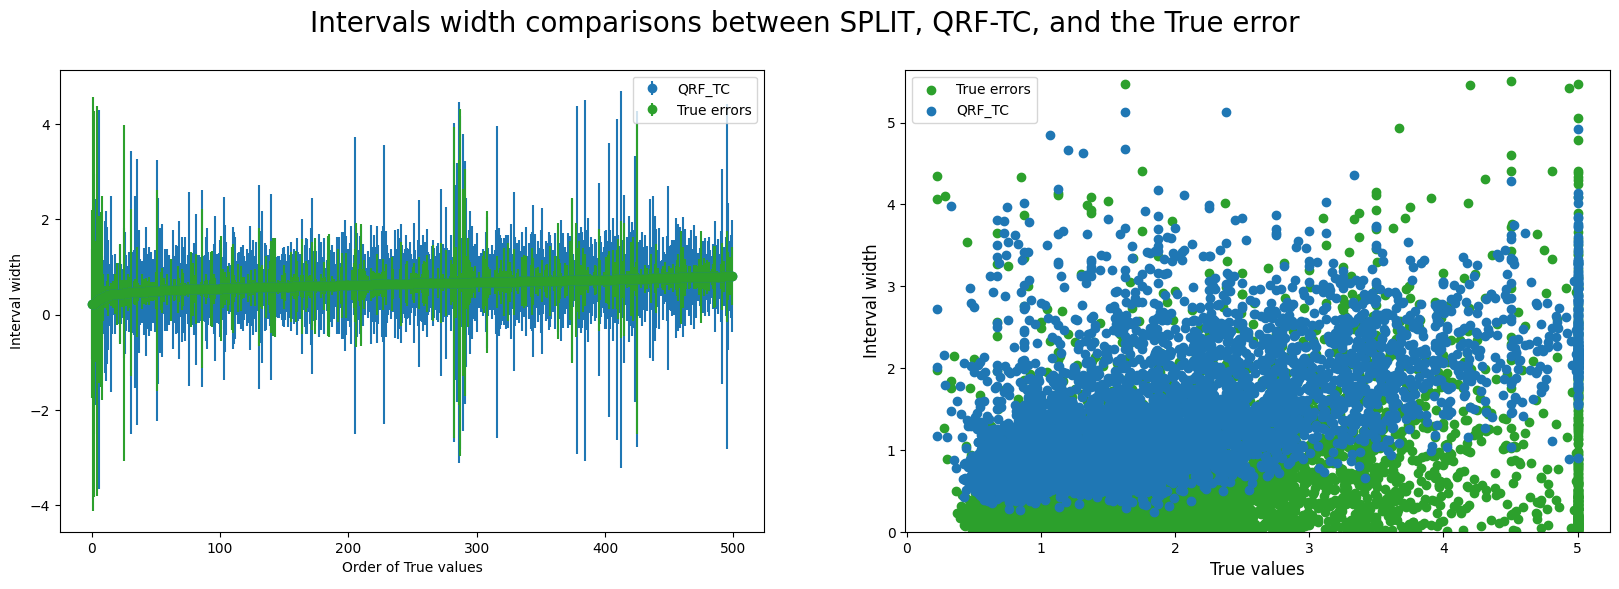

In [15]:
idx = list(range(len(y_test)))
sort_id = np.argsort(y_test)
max_size = 500

y_lower_true = model.predict(x_test) - np.abs(model.predict(x_test) - y_test)
y_upper_true = model.predict(x_test) + np.abs(model.predict(x_test) - y_test)
r = {'QRF_TC': y_upper - y_lower, 'True': y_upper_true - y_lower_true}

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].errorbar(idx[:max_size], y_test[sort_id][:max_size], yerr=r['QRF_TC'][sort_id][:max_size], fmt='o', label='QRF_TC', color='tab:blue')
ax[0].errorbar(idx[:max_size], y_test[sort_id][:max_size], yerr=r['True'][sort_id][:max_size], fmt='o', label='True errors', color='tab:green')
ax[0].set_ylabel('Interval width')
ax[0].set_xlabel('Order of True values')
ax[0].legend()

ax[1].scatter(y_test, r['True'], label='True errors', color='tab:green')
ax[1].scatter(y_test, r['QRF_TC'], label='QRF_TC', color='tab:blue')
ax[1].set_xlabel("True values", fontsize=12)
ax[1].set_ylabel("Interval width", fontsize=12)
ax[1].set_xscale("linear")
ax[1].set_ylim([0, np.max(r['QRF_TC'])*1.1])
ax[1].legend()

plt.suptitle('Intervals width comparisons between SPLIT, QRF-TC, and the True error ', size=20)
plt.show()
